# Robustness

In [297]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
from sklearn import linear_model
from sklearn import feature_selection
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import sklearn as sklearn
import multiprocessing

from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.ensemble import RandomTreesEmbedding
from sklearn.neural_network import MLPRegressor
#from sklearn.linear_model import ElasticNet
from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import Imputer
from sklearn import metrics

import xgboost as xgb

import statsmodels.api as sm
from keras import optimizers
from sklearn.linear_model import SGDRegressor
#import statsmodels.api as sm

from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l1

from sklearn import preprocessing

import copy

In [3]:
pd.set_option('display.max_columns', 500)

In [678]:
filename = '/Users/macbookpro/AirBnbPricePrediction/Data/listings.csv'
dataf = pd.read_csv(filename)

/var/folders/3h/240m_ld143b45thtn3x6_64r0000gn/T/ipykernel_42749/2981388428.py:2: DtypeWarning: Columns (43,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  dataf = pd.read_csv(filename)


In [679]:
len(dataf.columns)

96

## Data importation

In [359]:
#importing data without normalizing

from data_preprocessing_reviews import split

dataset = pd.read_csv('/Users/macbookpro/AirBnbPricePrediction/Data/data_cleaned.csv')
X_train, y_train, X_val, y_val, X_test, y_test = split(dataset)

coeffs = np.load('/Users/macbookpro/AirBnbPricePrediction/Data/selected_coefs_pvals.npy', allow_pickle=True)
#coeffs = np.load('/Users/macbookpro/AirBnbPricePrediction/Data/selected_coefs.npy', allow_pickle=True)

#column selection
col_set = set()
cherry_picked_list = [
'host_identity_verified',
'latitude',
'longitude',
'accommodates',
'bathrooms',
'bedrooms',
'beds',
'guests_included',
'security_deposit',
'cleaning_fee',
'extra_people',
'number_of_reviews',
'review_scores_rating',
'review_scores_accuracy',
'review_scores_cleanliness',
'review_scores_location',
'review_scores_value',
'reviews_per_month',
'comments'
]

for i in range(len(coeffs)):
    if (coeffs[i]):
        col_set.add(X_train.columns[i])
col_set.remove('square_feet') #too many nans
col_set.remove('has_availability') #uninformative one-hot
col_set.remove('is_business_travel_ready') #uninformative one-hot
col_set.remove('extra_people') #contains nonsensical values

X_train = X_train[list(col_set)]
X_val = X_val[list(col_set)]
X_test = X_test[list(col_set)]




Splitting dataset...
Dataset split


In [361]:
#adding prefixes to one-hot encoded columns

one_hot_cols = [col for col in list(col_set) if X_train[col].nunique()==2]
prefix_names = {} #one-hot column names with h_ prefix
for col in one_hot_cols:
    prefix_names[col] = f'h_{col}'
one_hot_cols_pref = list(prefix_names.values())
scalar_cols = list(set(col_set) - set(one_hot_cols))

X_train = X_train.rename(columns=prefix_names)
X_val = X_val.rename(columns=prefix_names)
X_test = X_test.rename(columns=prefix_names)

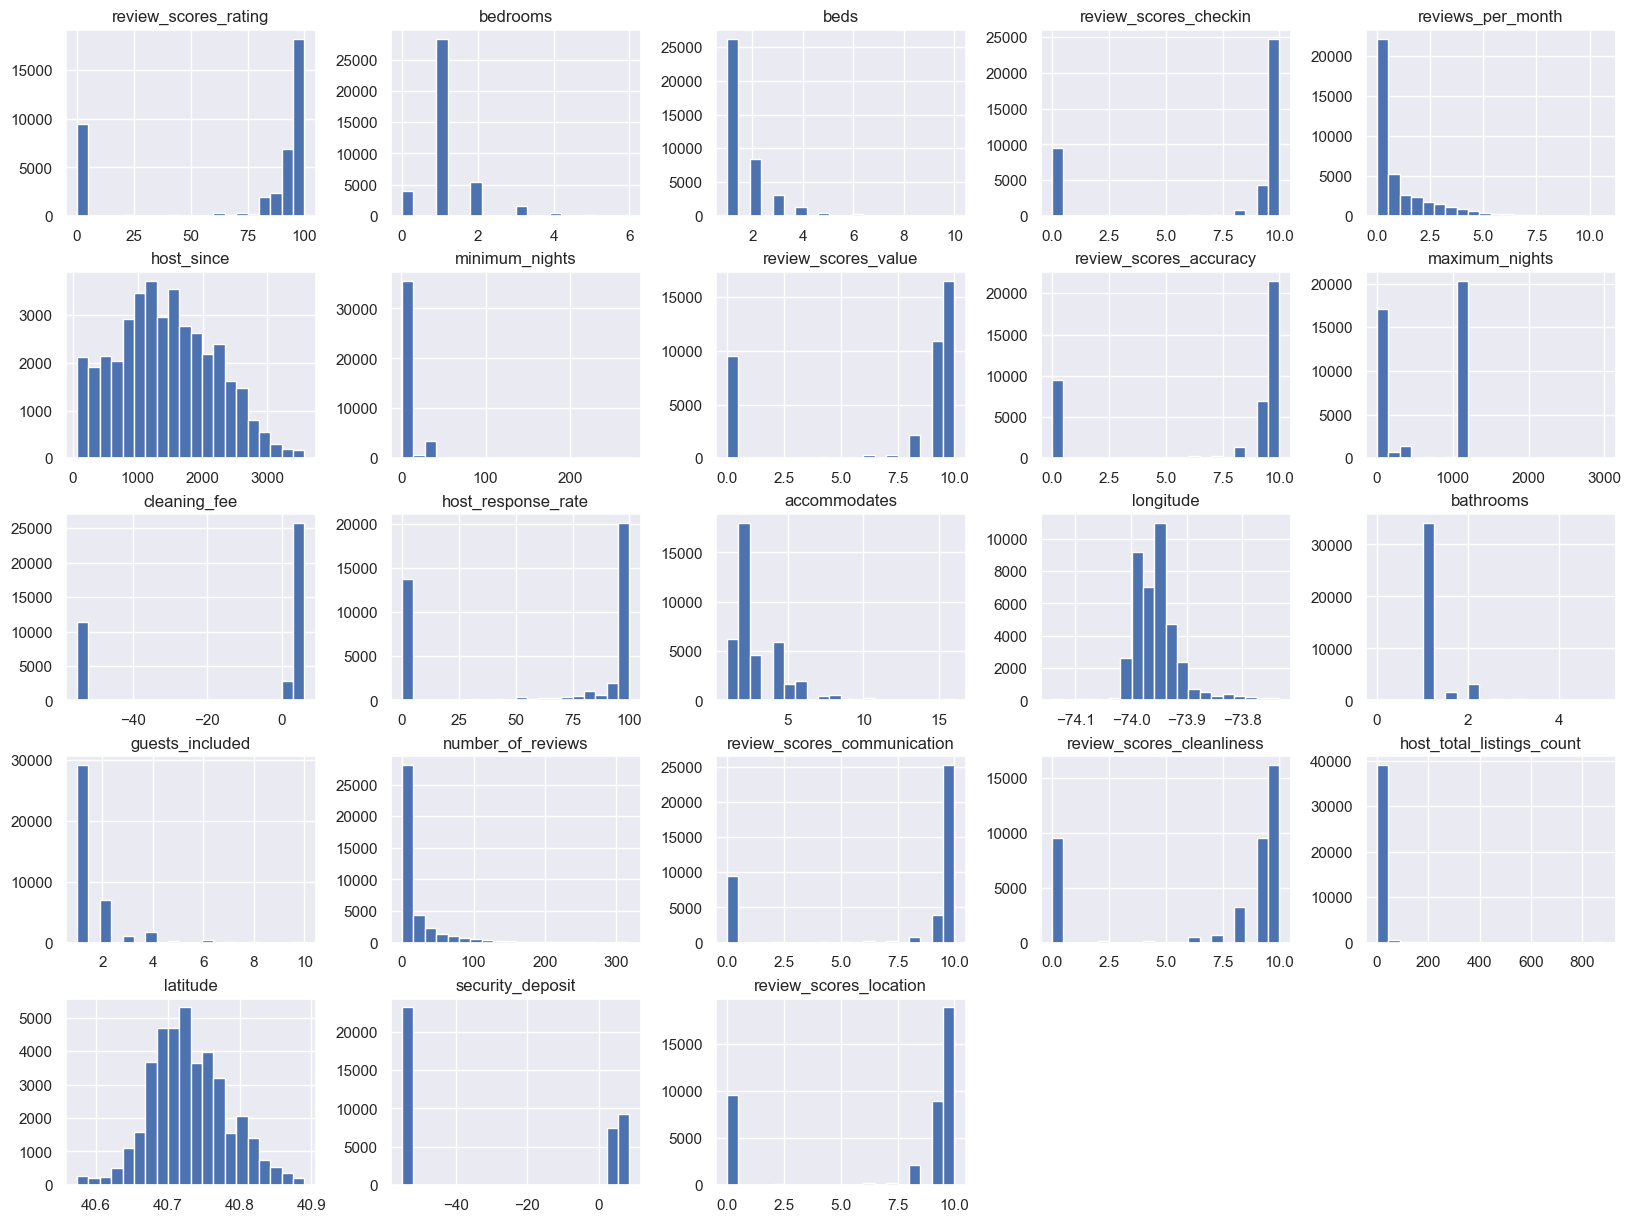

In [670]:
X_train[scalar_cols].hist(figsize=(20,15), bins=20)
plt.savefig('hist.png')
plt.show()

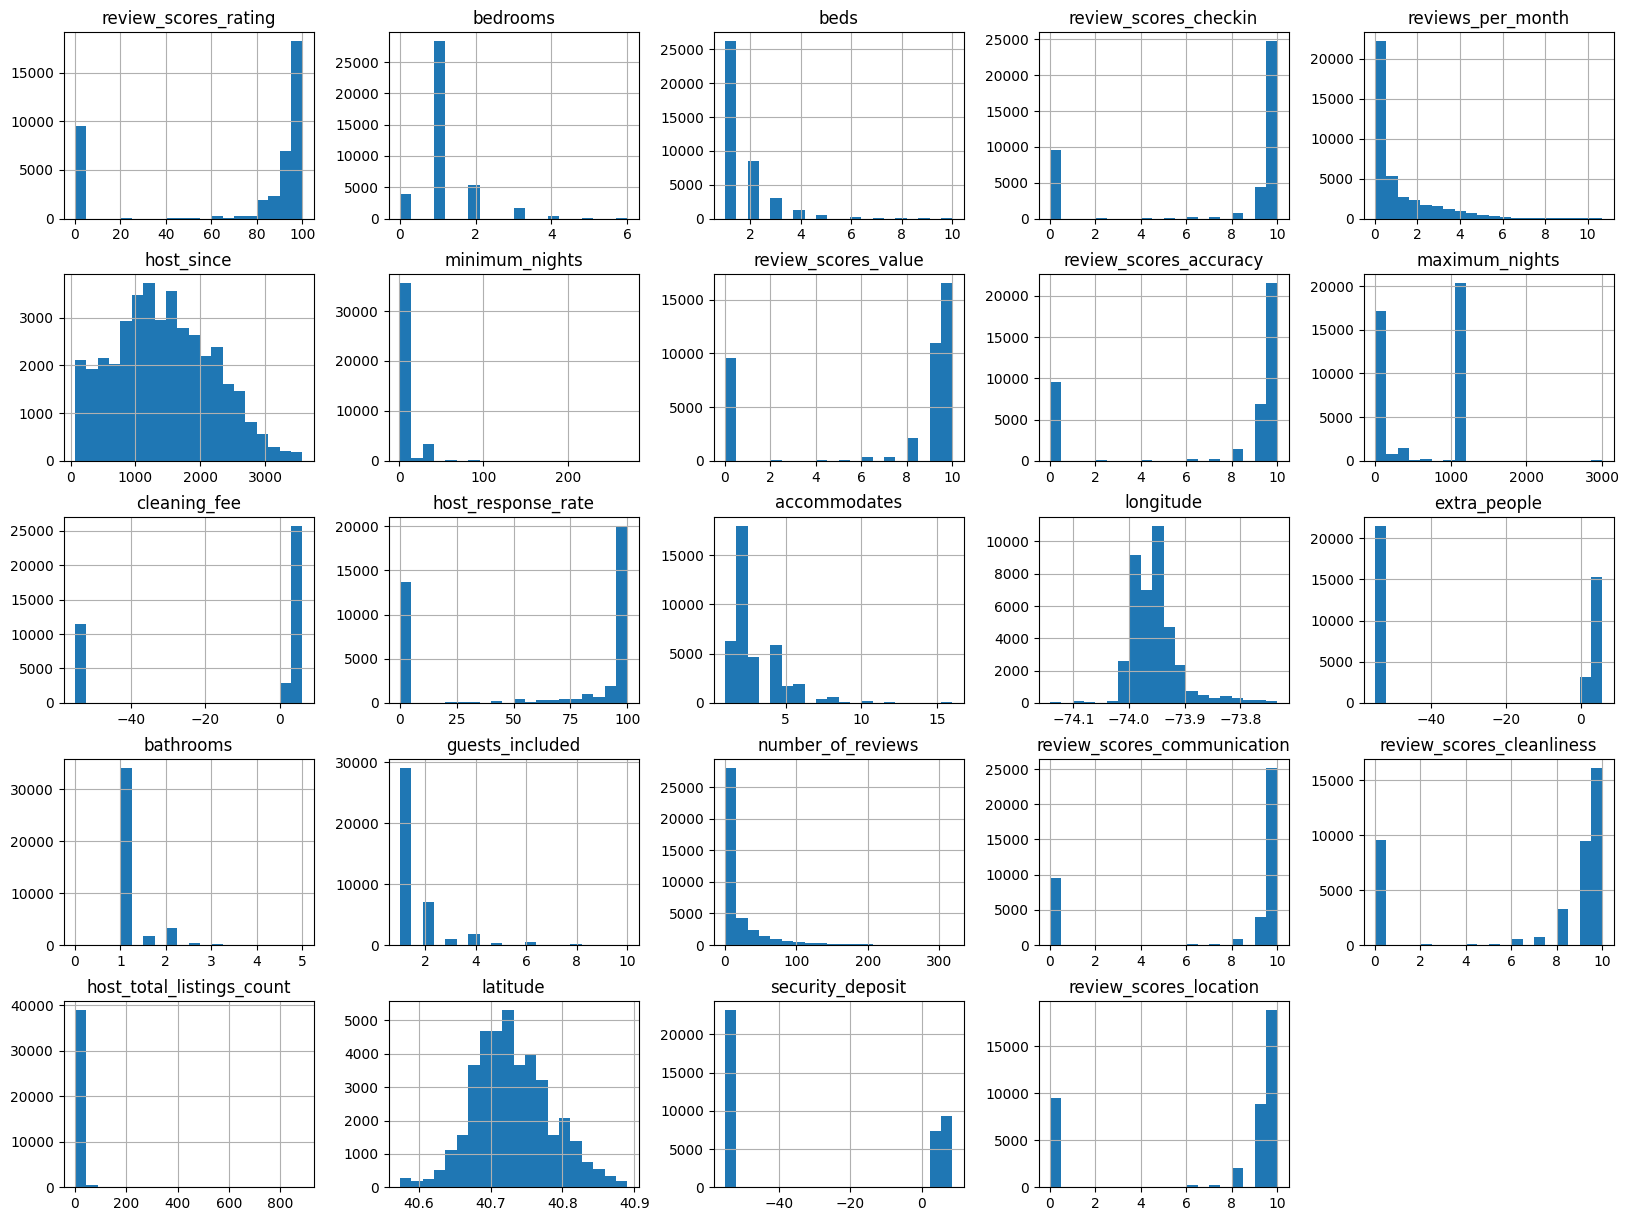

In [132]:
X_train[scalar_cols].clip( 
    lower=X_train[scalar_cols].quantile(0.001), 
    upper=X_train[scalar_cols].quantile(0.999), 
    axis=1).hist(figsize=(20,15), bins=20)
plt.show()

In [362]:
#removing outliers
X_train[scalar_cols] = X_train[scalar_cols].clip( 
    lower=X_train[scalar_cols].quantile(0.001), 
    upper=X_train[scalar_cols].quantile(0.999), 
    axis=1)

In [139]:
X_train

,h__toilet,h_Carbon_monoxide_detector,h_Cat(s),bedrooms,review_scores_rating,h_Baby_bath,h_Children’s_dinnerware,h_Other_pet(s),h_Fixed_grab_bars_for_toilet,h_Buzzer/wireless_intercom,h_Iron,h_Hot_tub,maximum_nights,h_Step-free_access,host_response_rate,h_Wide_clearance_to_shower,h_Electric_profiling_bed,h_Elevator,h_Smoke_detector,h_Wide_doorway,h_Luggage_dropoff_allowed,h_Mobile_hoist,h_Other,h_Pets_allowed,h_Table_corner_guards,h_Shower_chair,h_Lake_access,h_Free_street_parking,h_host_identity_verified,h_Wide_clearance_to_bed,beds,h_Host_greets_you,review_scores_checkin,reviews_per_month,h_Dog(s),h_Single_level_home,h_Ethernet_connection,host_since,h_Children’s_books_and_toys,minimum_nights,h_Pocket_wifi,h_require_guest_profile_picture,h_Dishes_and_silverware,h_host_has_profile_pic,review_scores_accuracy,cleaning_fee,accommodates,longitude,h_High_chair,h_Disabled_parking_spot,h_Flat_path_to_front_door,h_Building_staff,h_Hot_water,h_Baby_monitor,h_Fire_extinguisher,h_Dishwasher,h_Smoking_allowed,host_total_listings_count,h_Gym,h_Room-darkening_shades,h_Doorman,h_Wheelchair_accessible,h_Ceiling_hoist,h_Ground_floor_access,h_Paid_parking_on_premises,h_Hair_dryer,h_24-hour_check-in,h_Wide_hallway_clearance,h_Pack_’n_Play/travel_crib,h_Long_term_stays_allowed,h_Outlet_covers,h_Well-lit_path_to_entrance,h_TV,h_Crib,h_BBQ_grill,review_scores_value,h_Microwave,h_Stove,h_Kitchen,h_Bed_linens,h_Paid_parking_off_premises,h_Beach_essentials,h_Washer_/_Dryer,h_Refrigerator,h_Pool_with_pool_hoist,bathrooms,h_Private_bathroom,h_Pets_live_on_this_property,number_of_reviews,h_Lock_on_bedroom_door,h_EV_charger,review_scores_communication,h_Garden_or_backyard,h_Stair_gates,security_deposit,h_Coffee_maker,h_Smart_lock,h_Fixed_grab_bars_for_shower,h_Beachfront,h_Changing_table,h_require_guest_phone_verification,h_Cooking_basics,h_Private_entrance,h_Air_conditioning,h_Waterfront,h_Suitable_for_events,h_Shampoo,h_Dryer,h_host_is_superhost,h_Private_living_room,h_Bathtub_with_bath_chair,h_instant_bookable,h_Lockbox,h_Heating,guests_included,h_Handheld_shower_head,h_Laptop_friendly_workspace,h_Cable_TV,review_scores_cleanliness,latitude,h_Air_purifier,review_scores_location
45056,0,0,0,1.0,87.0,0,0,0,0,0,1,0,1125,0,100,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2.0,0,10.0,3.93,0,0,0,152.0,0,2.0,0,0,1,1,9.0,3.218876,3,-73.916183,0,0,0,0,0,0,1,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,9.0,1,1,1,0,0,0,0,1,0,1.0,0,0,11.0,1,0,10.0,0,0,-55.000000,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0,10.0,40.671145,0,7.0
8166,0,1,0,2.0,0.0,0,0,0,0,0,0,0,1125,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2.0,0,0.0,0.00,0,0,0,1420.0,0,4.0,0,0,0,1,0.0,3.688879,2,-73.970877,0,0,0,0,0,0,1,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0,0,1,0,0,0,0,0,0,1.0,0,0,0.0,0,0,0.0,0,0,6.214608,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,2,0,1,0,0.0,40.692031,0,0.0
45703,0,1,0,2.0,0.0,0,0,0,0,0,1,0,14,0,100,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3.0,1,0.0,0.00,0,0,1,390.0,0,2.0,0,0,0,1,0.0,4.382027,5,-73.877115,0,0,0,0,1,0,0,0,0,2.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0.0,0,0,1,1,0,0,0,0,0,1.0,0,0,0.0,1,0,0.0,0,0,4.605170,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,1,5,0,1,0,0.0,40.675865,0,0.0
7380,0,0,0,2.0,80.0,0,0,0,0,1,0,0,1125,0,100,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,2.0,0,8.0,0.07,0,0,0,3034.0,0,60.0,0,0,0,1,9.0,4.382027,2,-73.987491,0,0,0,0,1,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,7.0,0,0,1,0,1,0,0,0,0,1.0,0,0,2.0,0,0,8.0,0,0,-55.000000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,6.0,40.727977,0,10.0
16122,0,0,1,0.0,80.0,0,0,1,0,1,1,0,1125,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1.0,0,10.0,0.03,1,0,0,1336.0,0,1.0,0,0,0,1,8.0,-55.000000,2,-73.987575,0,0,0,0,0,0,0,0,0,1.0,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,8.0,0,0,1,0,0,0,0,0,0,1.0,0,1,1.0,0,0,10.0,0,0,-55.000000,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0,1,1,6.0,40.739261,0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [363]:
#data scaling

#scaler = preprocessing.StandardScaler()
scaler = preprocessing.MinMaxScaler()

print('Scaling X_train...')
train_idx = X_train.index
xtrain_sc = pd.DataFrame(scaler.fit_transform(X_train[scalar_cols]), columns=scalar_cols, index=train_idx)
X_train_scaled = xtrain_sc.join(X_train[one_hot_cols_pref])
print('X_train scaled')

print('Scaling X_val...')
val_idx = X_val.index
xval_sc = pd.DataFrame(scaler.fit_transform(X_val[scalar_cols]), columns=scalar_cols, index=val_idx)
X_val_scaled = xval_sc.join(X_val[one_hot_cols_pref])
print('X_val scaled')

print('Scaling X_test...')
test_idx = X_test.index
xtest_sc = pd.DataFrame(scaler.fit_transform(X_test[scalar_cols]), columns=scalar_cols, index=test_idx)
X_test_scaled = xtest_sc.join(X_test[one_hot_cols_pref])
print('X_test scaled')

Scaling X_train...
X_train scaled
Scaling X_val...
X_val scaled
Scaling X_test...
X_test scaled


In [364]:
X_concat_scaled = pd.concat([X_train_scaled, X_val_scaled], ignore_index=True)
y_concat = pd.concat([y_train, y_val], ignore_index=True)

In [142]:
def print_evaluation_metrics(trained_model, trained_model_name, X_test, y_test):
    print('--------- For Model: ', trained_model_name, ' ---------\n')
    predicted_values = trained_model.predict(X_test)
    print("Mean absolute error: ",
          metrics.mean_absolute_error(y_test, predicted_values))
    print("Median absolute error: ",
          metrics.median_absolute_error(y_test, predicted_values))
    print("Mean squared error: ", metrics.mean_squared_error(
        y_test, predicted_values))
    print("R2: ", metrics.r2_score(y_test, predicted_values))

## Fitting models

In [580]:
NUM_ITERATIONS = 150#
BATCH_SIZE = 256
LEARNING_RATE = 0.001
LASSO_COEF = 50.0
DECAY_RATE = 0.0001

def fit_nn(X_train=X_train_scaled, y_train=y_train, X_test=X_test_scaled, y_test=y_test, n_iter=NUM_ITERATIONS):
    model = Sequential()
    model.add(Dense(units=20, activation='relu', input_dim=len(X_train.values[0])))
    model.add(Dense(units=5, activation='relu'))
    model.add(Dense(units=1, activation='linear'))
    adam = optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=DECAY_RATE, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer=adam)
    history = model.fit(X_train, y_train, epochs=NUM_ITERATIONS, batch_size=BATCH_SIZE)
    print("finished fitting")
    #print_evaluation_metrics(model, "NN", X_train, y_train)
    #print_evaluation_metrics(model, "NN", X_test, y_test)

    return model
    
def fit_svr(X_train=X_train_scaled, y_train=y_train):
    model_svr = SVR(gamma = 0.05, verbose = True) #was empty #0.1 #the - best gamma 0.05, c=0.5
    model_svr.fit(X_train, y_train)
    return model_svr

def fit_lm(X_train=X_train_scaled, y_train=y_train):
    model_lm = linear_model.LinearRegression().fit(X_train.values, y_train)
    return model_lm

def fit_lasso(X_train=X_train_scaled, y_train=y_train):
    model_lasso = Lasso(alpha = 0.001) #0.5
    model_lasso.fit(X_train.values, y_train)
    return model_lasso

def fit_ridge(X_train=X_train_scaled, y_train=y_train):
    model_ridge = Ridge(alpha=7)
    model_ridge.fit(X_train.values, y_train)
    return model_ridge

def fit_gb(X_train=X_train_scaled, y_train=y_train):
    model_gb = GradientBoostingRegressor(max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        loss='squared_error')
    model_gb.fit(X_train.values, y_train)
    return model_gb

def fit_xgb(X_train=X_train_scaled, y_train=y_train):
    #dtrain = xgb.DMatrix(X_train, label=y_train)
    
    model_xgb = xgb.XGBRegressor(
        colsample_bytree=0.8, 
        gamma=0, 
        learning_rate=0.05, 
        max_depth=6, 
        n_estimators=150, 
        subsample=0.8)
    model_xgb.fit(X_train, y_train)

    return model_xgb

In [520]:
model_lm = fit_lm()
print('Linear model fitted')
model_lasso = fit_lasso()
print('Lasso fitted')
model_ridge = fit_ridge()
print('Ridge fitted')
model_gb = fit_gb()
print('Gradient Boosting fitted')
model_xgb = fit_xgb()
print('XGBoost fitted')
#mode_svr = fit_svr()
#print('SVR fitted')
model_nn = fit_nn()
print('NN fitted')


Linear model fitted
Lasso fitted
Ridge fitted
Gradient Boosting fitted
XGBoost fitted
Epoch 1/150
157/157 [==============================] - 3s 7ms/step - loss: 4.8649
Epoch 2/150
157/157 [==============================] - 1s 4ms/step - loss: 0.6030
Epoch 3/150
157/157 [==============================] - 1s 5ms/step - loss: 0.3916
Epoch 4/150
157/157 [==============================] - 1s 5ms/step - loss: 0.3449
Epoch 5/150
157/157 [==============================] - 1s 5ms/step - loss: 0.3209
Epoch 6/150
157/157 [==============================] - 1s 5ms/step - loss: 0.3030
Epoch 7/150
157/157 [==============================] - 1s 5ms/step - loss: 0.2885
Epoch 8/150
157/157 [==============================] - 1s 5ms/step - loss: 0.2760
Epoch 9/150
157/157 [==============================] - 1s 5ms/step - loss: 0.2653
Epoch 10/150
157/157 [==============================] - 1s 4ms/step - loss: 0.2559
Epoch 11/150
157/157 [==============================] - 1s 4ms/step - loss: 0.2475
Epoch 12/1

## Robustness

### Using random generation

#### Bayesian parameter estimation

We determine a parametric distribution of each feature using Bayesian inference.

In [51]:
import pymc as pm
import arviz as az
import scipy.stats as st
from tqdm.notebook import tqdm

In [446]:
#clipping for Bayesian inference
X_train_scaled[scalar_cols] = X_train_scaled[scalar_cols].clip(lower=0.0001, upper=0.9999)

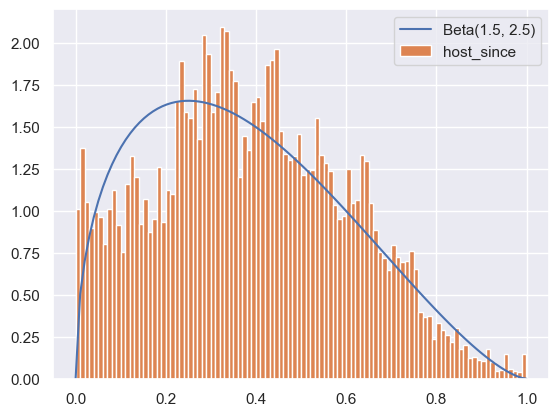

In [661]:
X = np.linspace(0,1,100)
y = st.beta.pdf(X, a=1.5, b=2.5)
y_true = X_train_scaled['host_since'].values

plt.plot(X, y, label='Beta(1.5, 2.5)')
plt.hist(y_true, bins=100, density=True, label='host_since')
plt.legend()
plt.savefig('host_since_hist.png')
plt.show()

/Users/macbookpro/AirBnbPricePrediction/env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:670: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


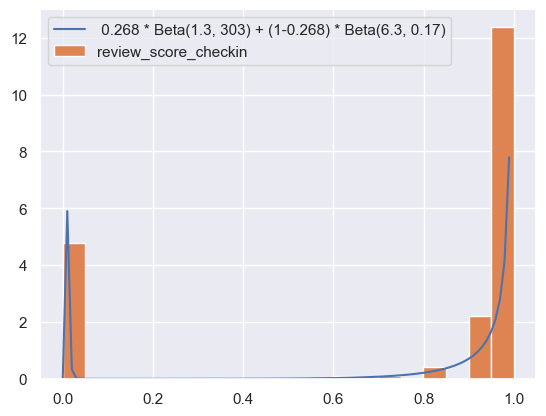

In [663]:

X = np.linspace(0,1,100)
y = (0.268*st.beta.pdf(X, a=1.3, b=303) + (1-0.268)*st.beta.pdf(X, a=6.3 , b=0.17))
y_true = X_train_scaled['review_scores_checkin'].values

plt.plot(X, y, label=' 0.268 * Beta(1.3, 303) + (1-0.268) * Beta(6.3, 0.17)')
plt.hist(y_true, bins=20, density=True, label='review_score_checkin')
plt.legend()
plt.savefig('review_score_checkin_hist.png')
plt.show()

In [148]:
num_beta_dist = {'review_scores_rating': 2,
 'bedrooms': 1,
 'beds': 1,
 'review_scores_checkin': 2,
 'reviews_per_month': 1,
 'host_since': 1,
 'minimum_nights': 1,
 'review_scores_value': 2,
 'review_scores_accuracy': 2,
 'maximum_nights': 1,
 'cleaning_fee': 2,
 'host_response_rate': 2,
 'accommodates': 1,
 'longitude': 2,
 'bathrooms': 1,
 'guests_included': 1,
 'number_of_reviews': 1,
 'review_scores_communication': 2,
 'host_total_listings_count': 1,
 'review_scores_cleanliness': 2,
 'latitude': 1,
 'security_deposit': 1,
 'review_scores_location': 2}




In [ ]:
#get the beta distribution parameters for scalar features

beta_dist_params = {}

for i, col in enumerate(num_beta_dist.keys()):
    print(f'==={i+1}/{len(num_beta_dist)}===')
    with pm.Model() as model:
        #a single beta distribution
        if num_beta_dist[col] == 1:
            alpha = pm.HalfNormal('alpha', 50)
            beta =pm.HalfNormal('beta', 50)
            host_since = pm.Beta('host_since', alpha=alpha, beta=beta, observed=X_train_scaled[col].iloc[500])
            idata = pm.sample()
            beta_dist_params[col] = [idata.posterior['alpha'].mean(),
                                    idata.posterior['beta'].mean()]
    
        #mixture model of beta distributions
        elif num_beta_dist[col] == 2:
            alpha1 = pm.HalfNormal('alpha1', 1)
            alphadiff = pm.HalfNormal('alphadiff', 50)
            alpha2 = pm.Deterministic('alpha2', alpha1 + alphadiff)

            beta2 = pm.HalfNormal('beta2', 1)
            betadiff = pm.HalfNormal('betadiff', 50)
            beta1 = pm.Deterministic('beta1', beta2 + betadiff)

            p = pm.LogitNormal('p')
            w = [p, 1-p]
            dist0 = pm.Beta.dist(alpha=alpha1, beta=beta1)
            dist1 = pm.Beta.dist(alpha=alpha2, beta=beta2)
            comp_dists = [dist0, dist1]
            obs = pm.Mixture('obs', w=w, comp_dists=comp_dists, observed=X_train_scaled[col].iloc[:500])
            idata = pm.sample()
            beta_dist_params[col] = [idata.posterior['p'].mean(),
                                    idata.posterior['alpha1'].mean(),
                                    idata.posterior['beta1'].mean(),
                                    idata.posterior['alpha2'].mean(),
                                    idata.posterior['beta2'].mean()]

    

In [460]:
#get the binomial distribution parameter for one-hot encoded features
binom_dist_params = {}
for col in one_hot_cols_pref:
    binom_dist_params[col] = X_train_scaled[col].mean()

In [465]:
#generating adversarial data
def generate_random_rows(
    beta_dist_params=beta_dist_params, 
    binom_dist_params=binom_dist_params,
    n=100):

    random_rows = {}
    #scalar features
    for col in scalar_cols:
        params = beta_dist_params[col]
        #feature modeled by 1 beta distribution
        if len(params) == 2:
            random_rows[col] = sc.stats.beta.rvs(a=float(params[0]), b=float(params[1]), size=n)
        #feature modeled by a mixture of 2 beta distributions
        elif len(params) == 5:
            p = float(params[0])
            bern = sc.stats.bernoulli.rvs(p=p, size=n)
            random_rows[col] = bern*sc.stats.beta.rvs(
                a=float(params[1]), 
                b=float(params[2]), 
                size=n) + (1-bern)* sc.stats.beta.rvs(
                a=float(params[3]), 
                b=float(params[4]), 
                size=n)
    
    #one hot encoded features
    for col in one_hot_cols_pref:
        random_rows[col] = sc.stats.bernoulli.rvs(p=binom_dist_params[col], size=n)

    X_random_rows_df = pd.DataFrame(random_rows)

    
    return X_random_rows_df
    

In [469]:
with pm.Model() as model:
    alpha = pm.HalfNormal('alpha', 50)
    beta =pm.HalfNormal('beta', 50)
    y_train_clipped = y_train.clip(lower=0.0001)
    price = pm.Gamma('price', alpha=alpha, beta=beta, observed=y_train_clipped.iloc[:500])
    idata = pm.sample()

    price_params = [idata.posterior['alpha'].mean(),
                    idata.posterior['beta'].mean()]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 43 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [553]:
def generate_random_prices(price_params=price_params, n=100):
    random_prices = sc.stats.gamma.rvs(a=price_params[0], scale=1/price_params[1], size=n)
    return pd.Series(random_prices)

In [554]:
X_random = generate_random_rows(n=20000)
y_random = generate_random_prices(price_params, n=20000)

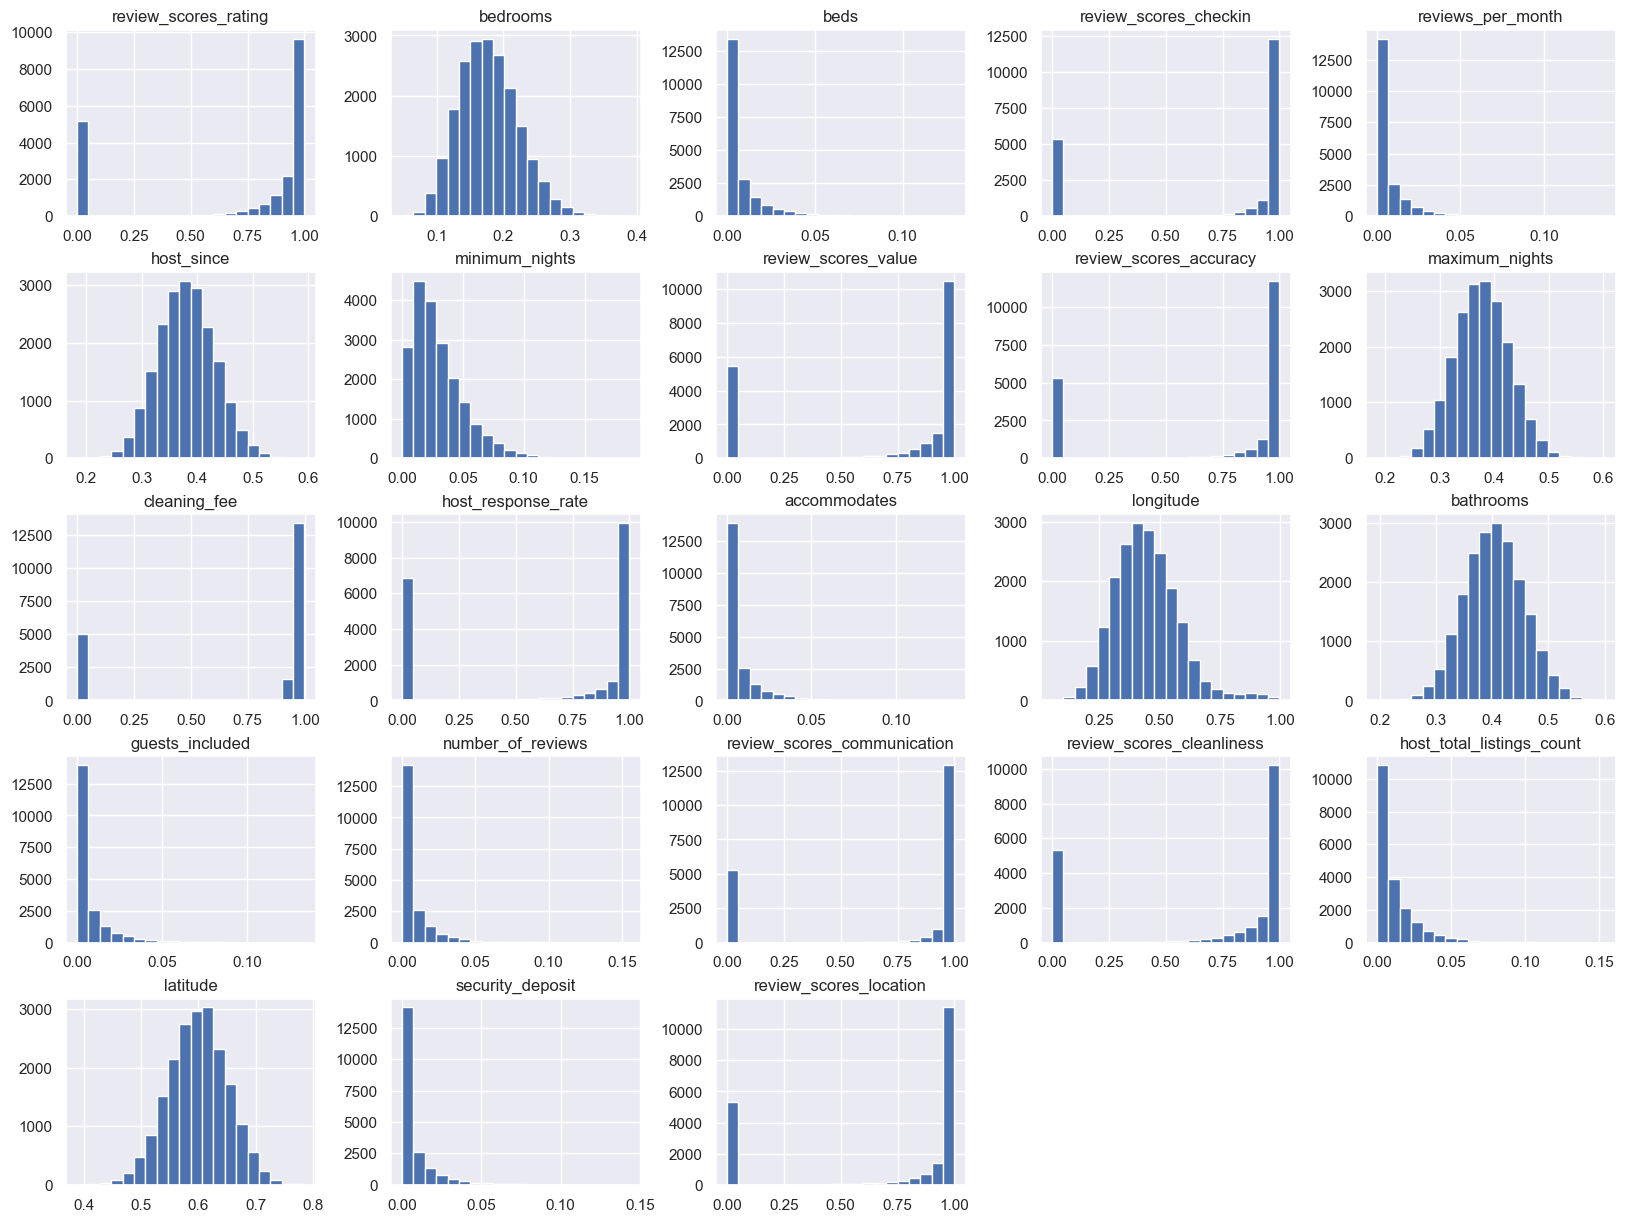

In [540]:
#checking the data distribution
X_random[scalar_cols].hist(figsize=(20,15), bins=20)
plt.show()

#### Fitting models using random data

In [585]:
def fit_models(X_train, y_train):
    model_lm = fit_lm(X_train, y_train)
    print('Linear model fitted')
    model_lasso = fit_lasso(X_train, y_train)
    print('Lasso fitted')
    model_ridge = fit_ridge(X_train, y_train)
    print('Ridge fitted')
    model_gb = fit_gb(X_train, y_train)
    print('Gradient Boosting fitted')
    model_xgb = fit_xgb(X_train, y_train)
    print('XGBoost fitted')
    #mode_svr = fit_svr()
    #print('SVR fitted')
    model_nn = fit_nn(X_train, y_train)
    print('NN fitted')
    return model_lm, model_lasso, model_ridge, model_gb, model_xgb, model_nn

def fit_models_rand_data(proportion=0.1):
    if proportion>0:
        n_rows = int(len(X_train_scaled)*proportion)
        X_train_concat = pd.concat((X_train_scaled.iloc[n_rows:], X_random.iloc[:n_rows]), axis=0, ignore_index=True)
        y_train_concat = pd.concat((y_train.iloc[n_rows:], y_random.iloc[:n_rows]), ignore_index=True)
        return fit_models(X_train_concat, y_train_concat)
    else:
        return fit_models(X_train_scaled, y_train)

def get_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test.values)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [628]:
#fitting models on data with different proportions of randomly generated rows
#that follow the distribution of the original data
proportions = [0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
models_str = ['lm', 'lasso', 'ridge', 'gb', 'xgb', 'nn']

def get_metrics_rand_data(proportions=proportions):
    metrics_dict = {}
    for model in models_str:
        metrics_dict[model] = [[], []] #{'model':[[mse], [r2]]}

    for p in proportions:
        print(f'--- p = {p} ---')
        model_lm, model_lasso, model_ridge, model_gb, model_xgb, model_nn = fit_models_rand_data(proportion=p)
        models = [model_lm, model_lasso, model_ridge, model_gb, model_xgb, model_nn]
        for i, model in enumerate(models):
            mse, r2 = get_metrics(model, X_test_scaled, y_test)
            metrics_dict[models_str[i]][0].append(mse)
            metrics_dict[models_str[i]][1].append(r2)
    return metrics_dict

metrics_dict2 = get_metrics_rand_data()


--- p = 0 ---
Linear model fitted
Lasso fitted
Ridge fitted
Gradient Boosting fitted
XGBoost fitted
Epoch 1/150
157/157 [==============================] - 2s 5ms/step - loss: 10.5611
Epoch 2/150
157/157 [==============================] - 1s 4ms/step - loss: 0.7431
Epoch 3/150
157/157 [==============================] - 1s 4ms/step - loss: 0.4597
Epoch 4/150
157/157 [==============================] - 1s 5ms/step - loss: 0.3709
Epoch 5/150
157/157 [==============================] - 1s 4ms/step - loss: 0.3306
Epoch 6/150
157/157 [==============================] - 1s 5ms/step - loss: 0.3059
Epoch 7/150
157/157 [==============================] - 1s 6ms/step - loss: 0.2866
Epoch 8/150
157/157 [==============================] - 1s 5ms/step - loss: 0.2705
Epoch 9/150
157/157 [==============================] - 1s 5ms/step - loss: 0.2568
Epoch 10/150
157/157 [==============================] - 1s 5ms/step - loss: 0.2462
Epoch 11/150
157/157 [==============================] - 1s 4ms/step - loss: 0.

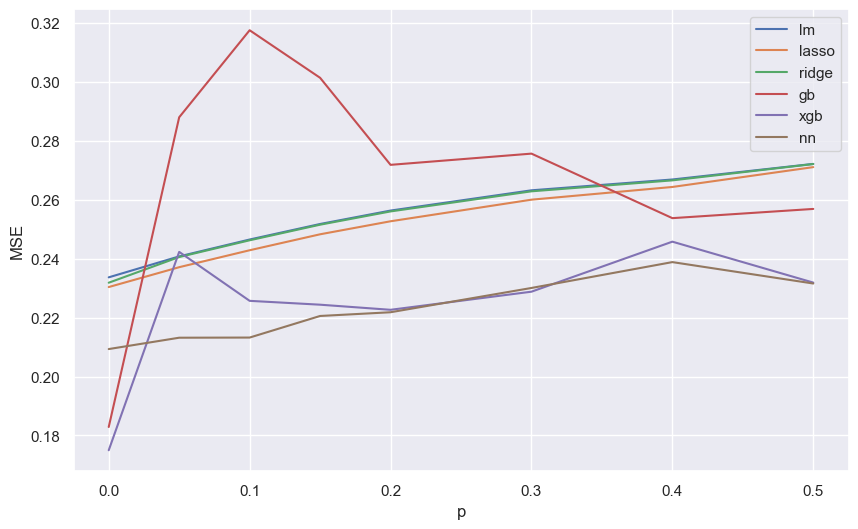

In [632]:
fig, ax = plt.subplots(1, figsize=(10,6))
for i, model in enumerate(models_str):
    ax.plot(proportions, metrics_dict2[model][0], label=models_str[i])
    #axes[1].plot(proportions, metrics_dict[model][1], label=models_str[i])
ax.set_xlabel('p')
ax.set_ylabel('MSE')

plt.legend()
plt.savefig('random_rows1.png')
plt.show()

In [616]:
lm=fit_lm(X_train_scaled, y_train)
pred_lm = lm.predict(X_test)
mse= mean_squared_error(y_test, pred_lm)
r2 = r2_score(y_test, pred_lm)

/Users/macbookpro/AirBnbPricePrediction/env/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


### Using FGSM

In [205]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [514]:
def fgsm(model, x, y_true, eps=0.05):
    '''Generates an adversarial example close to the input x.'''
    # Compute the gradients of the loss with respect to the input
    loss_object = keras.losses.MeanSquaredError()
    
    with tf.GradientTape() as tape:
        tape.watch(x)
        y_pred = model(x)
        loss = loss_object(y_true, y_pred)
    gradient = tape.gradient(loss, x)

    # Compute the sign of the gradient
    sign_gradient = tf.sign(gradient)

    # Add perturbation to the input
    x_adv = x + eps * sign_gradient

    # Clip the adversarial example so that it stays within the valid range
    x_adv = tf.clip_by_value(x_adv, 0, 1)
    mask = [False for i in range(len(scalar_cols))] + [True for i in range(len(one_hot_cols_pref))]
    x_adv = tf.where(mask, tf.round(x_adv), x_adv)

    return x_adv


In [515]:
def get_adv_tensor(model, X_test_scaled=X_test_scaled, y_test=y_test, n=10, eps=0.01):
    '''Generates n adversarial examples in a tf tensor'''
    #select test points and convert to tf tensor
    X_test_points = X_test_scaled.sample(n, random_state=42)
    idx_set = X_test_points.index
    y_true = y_test.loc[idx_set].values
    X_test_points = tf.constant(X_test_points.values)
    X_test_points = tf.reshape(X_test_points, shape=(n, 1, 122))
    
    #create adversarial points
    X_adv = [fgsm(model, X_test_points[i], y_true[i], eps) for i in range(n)]
    X_adv = tf.stack(X_adv)

    return X_test_points, X_adv, y_true

def adversarial_perf(model, X_test_points, X_adv, y_true):
    """Computes the performance of the model on the adversarial examples."""
    if type(model)==Sequential:
        y_pred = model.predict(X_test_points).flatten()
        y_pred_adv = model.predict(X_adv).flatten()
        
    else:
        shape = X_test_points.shape
        X_test_points = np.array(X_test_points).reshape((shape[0], shape[2]))
        X_adv = np.array(X_adv).reshape((shape[0], shape[2]))
        y_pred = model.predict(X_test_points)
        y_pred_adv = model.predict(X_adv)
    
    mse = mean_squared_error(y_true, y_pred)
    mse_adv = mean_squared_error(y_true, y_pred_adv)

    return mse, mse_adv
    

In [ ]:
#eps = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]
eps = np.linspace(0,0.49,30)
models = [model_lm, model_lasso, model_ridge, model_nn, model_gb, model_xgb]
models_str = ['lm', 'lasso', 'ridge', 'nn', 'gb', 'xgb']
mse_dict = {}
for model in models_str:
    mse_dict[model] = [[], []]

for i, e in enumerate(eps):
    X_test_points, X_adv, y_true = get_adv_tensor(model_nn, eps=e, n=100)
    print(f'epsilon = {e}')
    for j, model in enumerate(models):   
        mse, mse_adv = adversarial_perf(model, X_test_points, X_adv, y_true)
        mse_dict[models_str[j]][0].append(mse)
        mse_dict[models_str[j]][1].append(mse_adv)

#mse_dict: {'model': [mse_list, mse_adv_list]}
print(mse_dict)

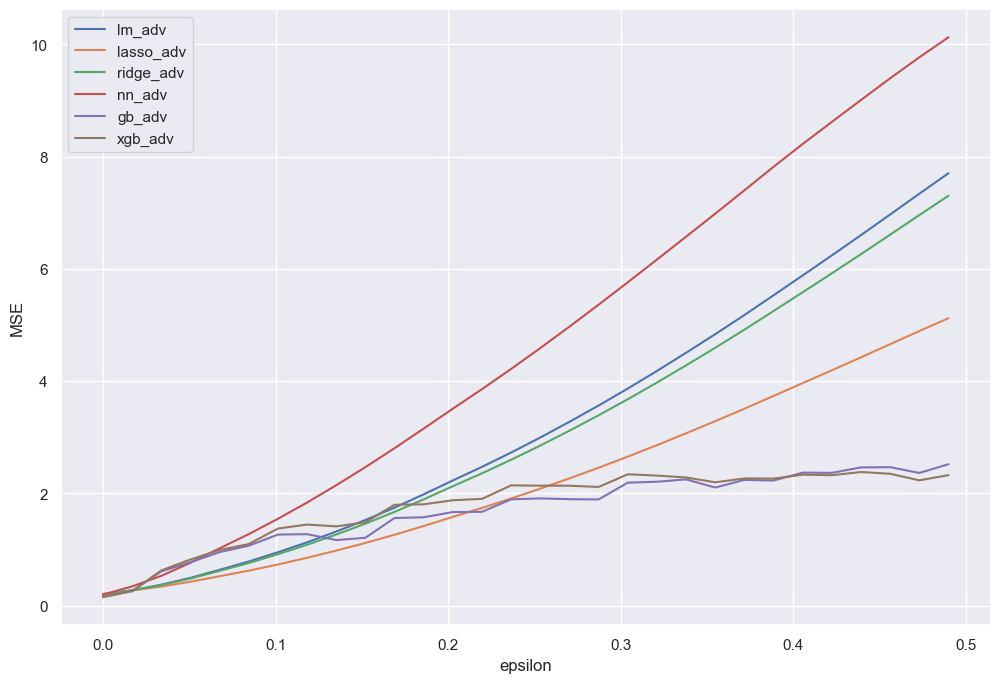

In [648]:
fig, ax = plt.subplots(figsize=(12,8))
for model in mse_dict.keys():
    #if model != 'lm':
    #plt.plot(eps, mse_dict[model][0], label=f'{model}_r')
    plt.plot(eps, mse_dict[model][1], label=f'{model}_adv')
ax.set_xlabel('epsilon')
ax.set_ylabel('MSE')
plt.legend()
plt.savefig('MSE_adv2')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 40))
ax.barh(X_train_scaled.columns, model_ridge.coef_)
plt.show()

In [482]:
def adversarial_perf2(model, X_test_points, X_adv, y_true, treshold):
    """Computes the performance of the model on the adversarial examples."""
    if type(model)==Sequential:
        y_pred = model.predict(X_test_points).flatten()
        y_pred_adv = model.predict(X_adv).flatten()
        
    else:
        shape = X_test_points.shape
        X_test_points = np.array(X_test_points).reshape((shape[0], shape[2]))
        X_adv = np.array(X_adv).reshape((shape[0], shape[2]))
        y_pred = model.predict(X_test_points)
        y_pred_adv = model.predict(X_adv)
    
    
    delta_adv = y_pred_adv - y_true
    delta_adv = np.where(abs(delta_adv)<treshold, 1, 0)
    #print(delta_adv)
    delta_original = y_pred - y_true
    delta_original = np.where(abs(delta_original)<treshold, 1, 0)
    

    return np.mean(delta_adv), np.mean(delta_original)



In [673]:
#eps = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]
eps = np.linspace(0, 0.1, 50)
models = [model_lm, model_lasso, model_ridge, model_nn, model_gb, model_xgb]
models_str = ['lm', 'lasso', 'ridge', 'nn', 'gb', 'xgb']
acc_dict = {}
for model in models_str:
    acc_dict[model] = [[], []]

for i, e in enumerate(eps):
    X_test_points, X_adv, y_true = get_adv_tensor(model_nn, eps=e, n=200)
    print(f'epsilon = {e}')
    for j, model in enumerate(models):   
        acc_adv, acc_original = adversarial_perf2(model, X_test_points, X_adv, y_true, 0.15)
        acc_dict[models_str[j]][0].append(acc_original)
        acc_dict[models_str[j]][1].append(acc_adv)

#mse_dict: {'model': [acc_adv, acc_original]}
#print(acc_dict)

epsilon = 0.0
7/7 [==============================] - 0s 5ms/step
epsilon = 0.0020408163265306124
7/7 [==============================] - 0s 3ms/step
epsilon = 0.004081632653061225
7/7 [==============================] - 0s 2ms/step
epsilon = 0.006122448979591837
7/7 [==============================] - 0s 2ms/step
epsilon = 0.00816326530612245
7/7 [==============================] - 0s 3ms/step
epsilon = 0.010204081632653062
7/7 [==============================] - 0s 2ms/step
epsilon = 0.012244897959183675
7/7 [==============================] - 0s 2ms/step
epsilon = 0.014285714285714287
7/7 [==============================] - 0s 2ms/step
epsilon = 0.0163265306122449
7/7 [==============================] - 0s 2ms/step
epsilon = 0.018367346938775512
7/7 [==============================] - 0s 2ms/step
epsilon = 0.020408163265306124
7/7 [==============================] - 0s 2ms/step
epsilon = 0.022448979591836737
7/7 [==============================] - 0s 2ms/step
epsilon = 0.02448979591836735
7/7 [

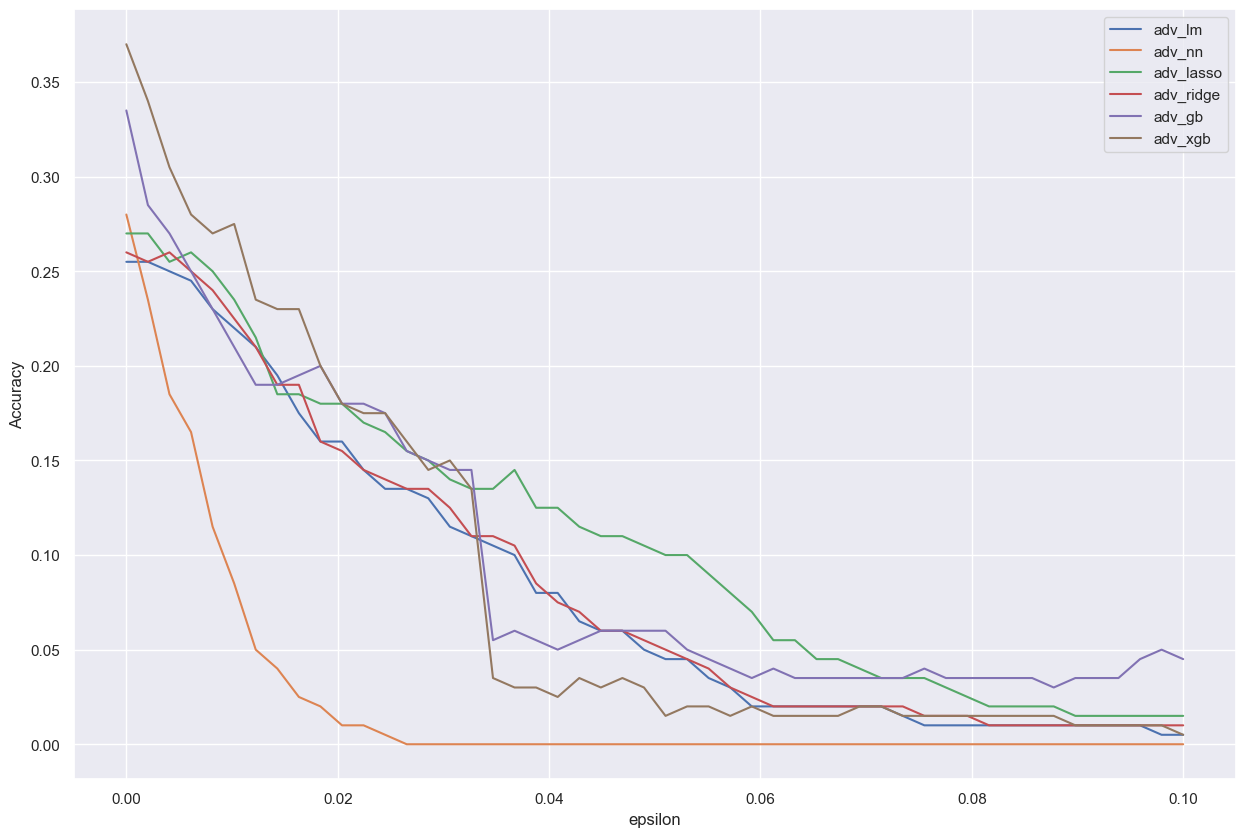

In [674]:
sns.set_theme()
fig, ax = plt.subplots(1, figsize=(15,10))
#ax.plot(eps, acc_dict['lm'][0] ,label='original')
ax.plot(eps, acc_dict['lm'][1], label='adv_lm')
ax.plot(eps, acc_dict['nn'][1], label='adv_nn')
ax.plot(eps, acc_dict['lasso'][1], label='adv_lasso')
ax.plot(eps, acc_dict['ridge'][1], label='adv_ridge')
ax.plot(eps, acc_dict['gb'][1], label='adv_gb')
ax.plot(eps, acc_dict['xgb'][1], label='adv_xgb')
ax.set_xlabel('epsilon')
ax.set_ylabel('Accuracy')
plt.legend()
plt.savefig('accuracyplot_thresh0.15_n200_linsp100_2.png')
plt.show()

In [407]:
ridge_coefs = pd.Series(model_ridge.coef_, index = X_train_scaled.columns)

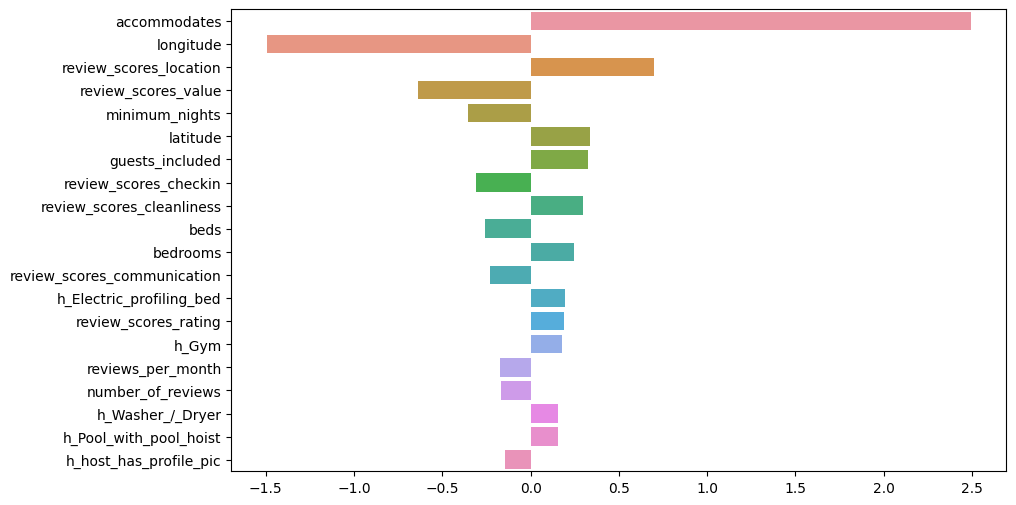

In [422]:
#plot the 20 most important features
import seaborn as sns
fix, ax = plt.subplots(figsize=(10, 6))
ridge_coefs_sorted = ridge_coefs[ridge_coefs.abs().sort_values(ascending=False).index]
sns.barplot(y=ridge_coefs_sorted.index[:20], x=ridge_coefs_sorted.values[:20], orient='h', ax=ax)
plt.savefig('coeffs_ridge_top20.png')

In [677]:
len(X_train) + len(X_test) + len(X_val)

49976